In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
sns.set(rc={'figure.figsize':(11, 4)})

In [2]:
data = pd.read_pickle("aggreg_PRODUCTION_data.pkl")
data.Date = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')
data = data[data.Date > '2012-12-31']
data=data.set_index('Date')
data.Energy_Generated=pd.to_numeric(data.Energy_Generated)

In [3]:
train_data = data[data.index < '2018-12-31']
test_data =data[data.index > '2018-12-31']

In [8]:
data.iloc[0,:]

Energy_Generated                  1013
Efficiency                       0.938
Energy_Exported                    998
Energy_Used                          0
Peak_Power                         807
Peak_Time                        13:10
Condition                      Showers
Min_Temperature                      8
Max_Temperature                     13
Peak_Energy_Import                 NaN
Off-Peak_Energy_Import             NaN
Shoulder_Energy_Import             NaN
High-Shoulder_Energy_Import        NaN
Insolation                        3458
Name: 2013-01-01 00:00:00, dtype: object

In [27]:
weekly_data_mean = train_data.Energy_Generated.resample('W').mean().dropna()
daily_data = train_data.Energy_Generated.dropna()

In [58]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return X, y

In [7]:
sc = MinMaxScaler()
training_data = sc.fit_transform(daily_data.values.reshape(-1,1))

n_steps = 28
# split into samples
X, y = split_sequence(training_data, n_steps)
# summarize the data
#for i in range(len(X)):
    #print(X[i], y[i])

In [8]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(X)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(X[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(X[train_size:len(X)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [49]:
class Vanilla_LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(Vanilla_LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = n_steps
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [13]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = Vanilla_LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

torch.Size([1, 1688, 2])
Epoch: 0, loss: 0.07232
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
t

torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])


torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])


torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
Epoch: 1000, loss: 0.05326
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2]

torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])


torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])


torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])
torch.Size([1, 1688, 2])


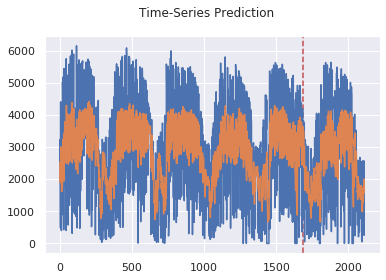

In [11]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [62]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)

        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 1)


    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)


    def forward(self, x):        
        batch_size, seq_len, _ = x.size()

        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

In [74]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [161]:
#daily_data_with_weather = train_data[['Condition','Min_Temperature','Max_Temperature','Energy_Generated']]
daily_data_with_weather = train_data[['Condition','Energy_Generated']]
encoder = LabelEncoder()
daily_data_with_weather.iloc[:,0] = encoder.fit_transform(daily_data_with_weather.iloc[:,0])
# ensure all data is float
daily_data_with_weather = daily_data_with_weather.astype('float32')

#daily_data_with_weather['Energy_Generated_x'] = daily_data_with_weather.Energy_Generated.shift(1)
daily_data_with_weather['Energy_Generated_x'] = daily_data_with_weather.Energy_Generated
daily_data_with_weather = daily_data_with_weather.dropna()
cols = daily_data_with_weather.columns.tolist()
cols = cols[-1:] + cols[:-1]
daily_data_with_weather = daily_data_with_weather[cols]
print(daily_data_with_weather.columns)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(daily_data_with_weather)

Index(['Energy_Generated_x', 'Condition', 'Energy_Generated'], dtype='object')


/home/zhe/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [162]:
n_features = 2 # this is number of parallel inputs
n_timesteps = 28 # this is number of timesteps

# convert dataset into input/output
X, y = split_sequences(scaled, n_timesteps)

# create NN
mv_net = MV_LSTM(n_features,n_timesteps)
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-1)

train_episodes = 350
batch_size = 16

In [163]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(X)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(X[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(X[train_size:len(X)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [164]:
loss_values = []
for t in range(train_episodes):
    mv_net.train()
    for b in range(0,len(trainX),batch_size):
        inpt = trainX[b:b+batch_size,:,:]
        target = trainY[b:b+batch_size]    

        x_batch = torch.tensor(inpt,dtype=torch.float32)    
        y_batch = torch.tensor(target,dtype=torch.float32)

        mv_net.init_hidden(x_batch.size(0))
        output = mv_net(x_batch) 
        loss = criterion(output.view(-1), y_batch)  

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 
    ##add test
    mv_net.eval()
    mv_net.init_hidden(testX.size(0))
    test_predict = mv_net(testX)
    loss = criterion(test_predict.view(-1), testY)  
    loss_values.append(loss)
    print("loss",t,loss)
    

/home/zhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/zhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


loss 0 tensor(0.0942, grad_fn=<MseLossBackward>)
loss 1 tensor(0.4566, grad_fn=<MseLossBackward>)
loss 2 tensor(0.2703, grad_fn=<MseLossBackward>)
loss 3 tensor(0.0976, grad_fn=<MseLossBackward>)
loss 4 tensor(0.0176, grad_fn=<MseLossBackward>)
loss 5 tensor(0.0046, grad_fn=<MseLossBackward>)
loss 6 tensor(0.0040, grad_fn=<MseLossBackward>)
loss 7 tensor(0.0045, grad_fn=<MseLossBackward>)
loss 8 tensor(0.0045, grad_fn=<MseLossBackward>)
loss 9 tensor(0.0045, grad_fn=<MseLossBackward>)
loss 10 tensor(0.0045, grad_fn=<MseLossBackward>)
loss 11 tensor(0.0047, grad_fn=<MseLossBackward>)
loss 12 tensor(0.0051, grad_fn=<MseLossBackward>)
loss 13 tensor(0.0059, grad_fn=<MseLossBackward>)
loss 14 tensor(0.0068, grad_fn=<MseLossBackward>)
loss 15 tensor(0.0071, grad_fn=<MseLossBackward>)
loss 16 tensor(0.0065, grad_fn=<MseLossBackward>)
loss 17 tensor(0.0057, grad_fn=<MseLossBackward>)
loss 18 tensor(0.0050, grad_fn=<MseLossBackward>)
loss 19 tensor(0.0045, grad_fn=<MseLossBackward>)
loss 20 te

loss 163 tensor(0.0052, grad_fn=<MseLossBackward>)
loss 164 tensor(0.0078, grad_fn=<MseLossBackward>)
loss 165 tensor(0.0088, grad_fn=<MseLossBackward>)
loss 166 tensor(0.0092, grad_fn=<MseLossBackward>)
loss 167 tensor(0.0051, grad_fn=<MseLossBackward>)
loss 168 tensor(0.0108, grad_fn=<MseLossBackward>)
loss 169 tensor(0.0102, grad_fn=<MseLossBackward>)
loss 170 tensor(0.0051, grad_fn=<MseLossBackward>)
loss 171 tensor(0.0088, grad_fn=<MseLossBackward>)
loss 172 tensor(0.0123, grad_fn=<MseLossBackward>)
loss 173 tensor(0.0049, grad_fn=<MseLossBackward>)
loss 174 tensor(0.0082, grad_fn=<MseLossBackward>)
loss 175 tensor(0.0128, grad_fn=<MseLossBackward>)
loss 176 tensor(0.0050, grad_fn=<MseLossBackward>)
loss 177 tensor(0.0081, grad_fn=<MseLossBackward>)
loss 178 tensor(0.0126, grad_fn=<MseLossBackward>)
loss 179 tensor(0.0052, grad_fn=<MseLossBackward>)
loss 180 tensor(0.0074, grad_fn=<MseLossBackward>)
loss 181 tensor(0.0137, grad_fn=<MseLossBackward>)
loss 182 tensor(0.0055, grad_fn

loss 324 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 325 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 326 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 327 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 328 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 329 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 330 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 331 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 332 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 333 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 334 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 335 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 336 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 337 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 338 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 339 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 340 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 341 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 342 tensor(0.0097, grad_fn=<MseLossBackward>)
loss 343 tensor(0.0097, grad_fn

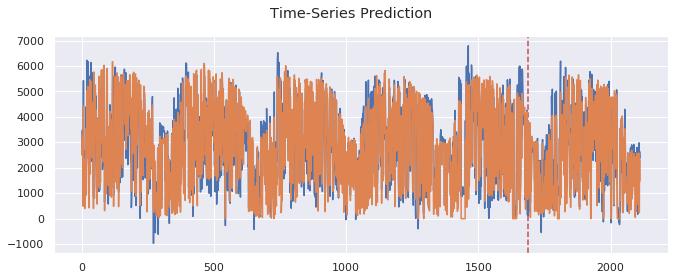

In [165]:
mv_net.eval()
mv_net.init_hidden(dataX.size(0))
train_predict = mv_net(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = np.c_[ data_predict, np.zeros(dataY_plot.shape[0]) ]
data_predict = np.c_[ data_predict, dataY_plot ]

data_predict = scaler.inverse_transform(data_predict)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(data_predict[:,0])
plt.plot(data_predict[:,2])
plt.suptitle('Time-Series Prediction')
plt.show()

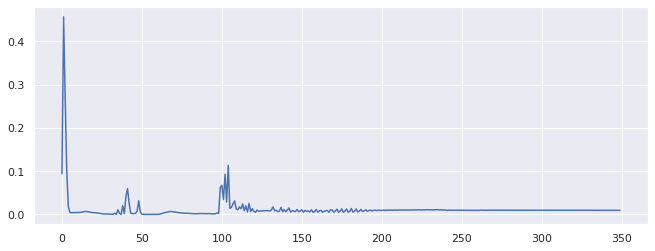

In [166]:
plt.plot(loss_values)
plt.show()

In [167]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(data_predict[:,2], data_predict[:,0])**1/2)

173609.83381508337
